# Simulations on Harmonic Oscillator Model
We present results on Jarzynski's equality based on the toy model desribed in https://link.aps.org/doi/10.1103/PhysRevE.56.5018.

Consider a harmonic oscillator Hamiltonian characterised by parameter $\omega_\lambda$. (Mass $m$ is set to 1.)
$$ H_\lambda = \frac{p^2}{2} + \omega_\lambda^2\frac{x^2}{2} $$

Hamilton equations are given as:
\begin{align*}
\dot{x} &= \frac{\partial H}{\partial p} = p \\
\dot{p} &= -\frac{\partial H}{\partial x} = -\omega_\lambda^2 x \\
\end{align*}

## Isolated Oscillator
The oscillator is assumed to be isolated from the environment. The frequency $\omega_\lambda$ is switched from $\omega_0$ to $\omega_1$ in time $t_s$. Initial values of $(x,p)$ are samples from a canonical distribution at temperature $\beta$, $f(x,p) = \frac{\beta \omega_0}{2 \pi} \exp\left( \beta(\frac{p^2}{2} + \omega_\lambda^2\frac{x^2}{2}) \right)$. $N$ independent evolutions are carried out and the work $W_i$ is calculated as $ W_i = \Delta H$ between $t=0$ and $t=t_s$.

We calculate the ensemble average of the work in two ways:
\begin{align*}
W^a &= \frac{1}{N} \sum W_i \\
W^x &= -\beta \log\left(\frac{1}{N} \sum \exp \left( -\beta W_i \right) \right)
\end{align*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate

In [50]:
class Work_Simulation:
    
    def __init__(self, beta = 1/1.5, omega_0 = 1.0, omega_1 = 2.0, t_s = 10):
        self.beta = beta
        self.omega_0 = omega_0
        self.omega_1 = omega_1
        self.t_s = t_s
        
    def get_y0(self):
        sigma_p = 1/np.sqrt(self.beta)
        sigma_x = 1.0/(self.omega_0 * np.sqrt(self.beta))
        x = np.random.normal(scale=sigma_x)
        p = np.random.normal(scale=sigma_p)
        self.y0 = np.array([x, p])
        
    def calculate_delta_f(self):
        pass
        
    def omega_t(self, t):
        return self.omega_0 + (self.omega_1 - self.omega_0)*(t/self.t_s)
    
    def calc_H(self, y, t):
        omega = self.omega_t(t)
        H = 0.5*y[1]**2 + 0.5*omega**2*y[0]**2
        return H
        
    def calc_W(self):
        y0 = self.res[0]
        y1 = self.res[-1]
        t = self.t
        W = self.calc_H(y1,t[-1]) - self.calc_H(y0,t[0])
        return W
    
    
        
    def dy_dt(self, y,t):
        dx_dt = y[1]
        dp_dt = -self.omega_t(t)**2 * y[0]
        return np.array([dx_dt,dp_dt])

    def simulate(self):
        N_t = 1000  # this does not affect the accuracy. Only for plotting purpose.
        t = np.linspace(0,self.t_s,N_t)
        res = scipy.integrate.odeint(self.dy_dt,self.y0,t)
        self.res = res
        self.t = t
        
        self.w = self.calc_W()
        

* Initialize a work_simulation object
* `get_y0()` -> obtains a phase space vector from exp(-BH(z))
* `simulate()` -> integrates the equations of motion

In [51]:
a = Work_Simulation()
a.get_y0()
a.simulate()

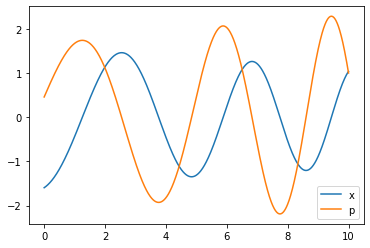

In [52]:
plt.plot(a.t, a.res[:, 0], label = 'x')
plt.plot(a.t, a.res[:, 1], label = 'p')
plt.legend(loc = 'best')

* Perform 10^4 simulations, each time obtaining a phase space vector from exp(-beta * H(z))
* For each t_s in [1, 3, 10, 31, 100]
* Obtain work matrix -> (5, 10000) -> work_[i] denotes 10^4 simulations performed for t_s[i]

In [92]:
Nsim = 1000000

#ts_values = np.logspace(0, 2, 5)
ts_values = np.array([10,])

final_phases = np.empty(shape = (ts_values.size, Nsim, 2))
works_a = np.zeros(shape = (ts_values.size, Nsim))
for i, ts in enumerate(ts_values):
    a = Work_Simulation(t_s = ts)
    for j in range(Nsim):
        a.get_y0()
        a.simulate()
        works_a[i, j] = a.w
        final_phases[i, j] = a.res[-1]

In [93]:
w_a = works_a.mean(axis = 1)
w_x = - 1 / (a.beta) * np.log(np.mean(np.exp(-a.beta * works_a), axis = 1))

In [94]:
w_x

array([1.03855694])

In [95]:
w_a

array([1.50147671])

In [96]:
works_a.max()

24.090195270346097

In [97]:
works_a.min()

1.040708285078867e-06

## Checking validity of Jarzynski equality

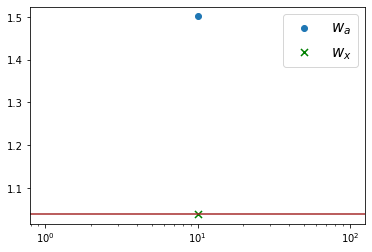

In [98]:
plt.scatter(ts_values, w_a, marker = 'o', label = r'$w_a$')
plt.scatter(ts_values, w_x, marker = 'x', color = 'green', s = 50, label = r'$w_x$')
plt.legend(loc='best', fontsize = 15)
delta_f = 1 / (a.beta) * np.log(a.omega_1 / a.omega_0)
plt.xscale('log')
plt.axhline(y = delta_f, color = 'brown')

In [146]:
bins_a = np.linspace(0, 20, 40)
bins_b = -bins_a[::-1]
nbins = bins_a.size - 1

In [147]:
rho_a = np.zeros(shape=(ts_values.size, nbins))
coords_a = np.zeros(shape = (ts_values.size, nbins))
for i, ts in enumerate(ts_values):
    rho_a[i], be = np.histogram(a.beta*works_a[i], bins = bins_a, density = True)
    coords_a[i] = (be[1:] + be[:-1]) / 2

## Backward simulations

* Initializing omega_0 = 2.0, omega_1 = 1.0
* This is a backward / conjugate process of the above
* process A : omega_A(t) = a + (b - a) * (t/ts)
* process B : omega_B(t) = b + (a - b) * (t / ts) 
* = a - (a - b) + (a - b) * (t / ts)
* = a + (a - b) * (1 - t / ts)
* = a + (a - b) * ((ts - t) / ts)
* = omega_a(ts - t)
* Here a = 1.0, b = 2.0
* Initializing the starting point of the simulation as ending point of (i, j) simulation of Proc. A

In [101]:
#Nsim = 1000000
#ts_values = np.logspace(0, 2, 5)

works_b = np.zeros(shape = (ts_values.size, Nsim))
for i, ts in enumerate(ts_values):
    b = Work_Simulation(omega_0 = 2.0, omega_1 = 1.0, t_s = ts)
    for j in range(Nsim):
        b.y0 = final_phases[i, j]
        b.simulate()
        works_b[i, j] = b.w

In [115]:
works_b.max()*b.beta

-6.94099353255814e-07

In [116]:
works_b.min()*b.beta

-16.070582157744994

In [150]:
rho_b = np.zeros(shape=(ts_values.size, nbins))
coords_b = np.zeros(shape = (ts_values.size, nbins))
for i, ts in enumerate(ts_values):
    rho_b[i], be = np.histogram(b.beta*works_b[i], bins = bins_b, density = True)
    coords_b[i] = (be[1:] + be[:-1]) / 2

In [119]:
works_c = np.zeros(shape = (ts_values.size, Nsim))
for i, ts in enumerate(ts_values):
    c = Work_Simulation(omega_0 = 2.0, omega_1 = 1.0, t_s = ts)
    for j in range(Nsim):
        c.get_y0()
        c.simulate()
        works_c[i, j] = c.w

In [120]:
works_c.max()*c.beta

-1.7657332529717745e-07

In [133]:
c.beta*works_c.min()

-6.681163788213735

In [153]:
bins_c = -bins_a[::-1]
rho_c = np.zeros(shape=(ts_values.size, nbins))
coords_c = np.zeros(shape = (ts_values.size, nbins))
for i, ts in enumerate(ts_values):
    rho_c[i], be = np.histogram(c.beta*works_c[i], bins = bins_c, density = True)
    coords_c[i] = (be[1:] + be[:-1]) / 2

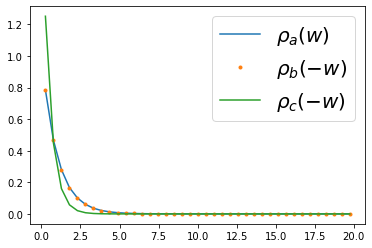

In [221]:
plt.plot(coords_a[0], rho_a[0], label = r'$\rho_a(w)$')
plt.plot(-coords_b[0], rho_b[0],'.', label = r'$\rho_b(-w)$')
plt.plot(-coords_c[0], rho_c[0], label = r'$\rho_c(-w)$')
plt.legend(loc='best', fontsize = 20)

## Below plot was expected to be a gaussian
### Attempting to validate CFT

In [204]:
expected_gauss = rho_a[0] / rho_b[0][::-1]

<ipython-input-204-faa2bfd460c8>:1: RuntimeWarning: invalid value encountered in true_divide
  expected_gauss = rho_a[0] / rho_b[0][::-1]


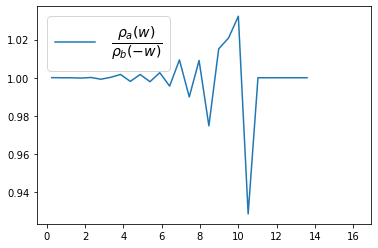

In [205]:
plt.plot(coords_a[0], expected_gauss, label = r'$\frac{\rho_a(w)}{\rho_b(-w)}$')
plt.legend(loc='best', fontsize = 20)

In [212]:
expected_gauss = rho_a[0] / rho_c[0][::-1]

<ipython-input-212-8b115aa66aca>:1: RuntimeWarning: divide by zero encountered in true_divide
  expected_gauss = rho_a[0] / rho_c[0][::-1]
<ipython-input-212-8b115aa66aca>:1: RuntimeWarning: invalid value encountered in true_divide
  expected_gauss = rho_a[0] / rho_c[0][::-1]


In [213]:
np.log(a.omega_1/a.omega_0)/a.beta

1.039720770839918

In [214]:
theory = np.exp(np.log(a.omega_1/a.omega_0)/a.beta + a.beta*coords_a[0])

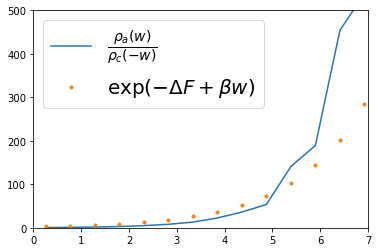

In [215]:
plt.plot(coords_a[0], expected_gauss, label = r'$\frac{\rho_a(w)}{\rho_c(-w)}$')
plt.plot(coords_a[0], theory, '.', label = r'$\exp{(-\Delta F + \beta w)}$')
plt.xlim(0,7)
plt.ylim(0,500)
plt.legend(loc='best', fontsize = 20)

In [216]:
theory = np.log(a.omega_1/a.omega_0)/a.beta + a.beta*coords_a[0]

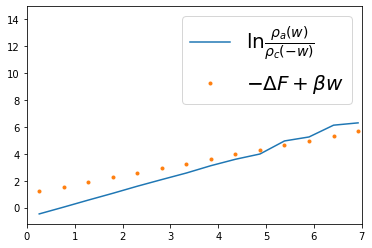

In [220]:
plt.plot(coords_a[0], np.log(expected_gauss), label = r'$\ln\frac{\rho_a(w)}{\rho_c(-w)}$')
plt.plot(coords_a[0], theory, '.', label = r'$-\Delta F + \beta w$')
plt.xlim(0,7)
plt.legend(loc='best', fontsize = 20)